In [1]:
%matplotlib inline


import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


pd.options.display.max_columns = 0

plt.rcParams.update({
    "font.family": ["serif"],
    "font.sans-serif": ["Roboto"],
    "font.size": 9,
    "axes.labelsize": 11,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    'figure.figsize': (15.0, 4.0),
    'axes.grid': False,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
})

np.set_printoptions(suppress=True)

warnings.filterwarnings('ignore')

# Scikit Learn:
- Lib para hacer Machine Learning
- Tanto los modelos en sí, como cosas típicas alrededor (métricas, preprocesado, etc)
- Muy modular: nos da bloques que nosotros enganchamos entre sí

# Pipeline, transformers & estimators

* **estimator**: un **modelo** de Machine Learning. Los métodos más importantes son:
    * fit(X, y): **X** es una matriz de la forma *(n_samples, n_features)*; **y** un array *(n_samples,)*. Devuelve una referencia al estimador
    * predict(X): **X** es una matriz de la forma *(n_samples, n_features)*. Devuelve un array *(n_samples,)* con las predicciones
    
* **Transformers** y **pre-processors**: Son objetos para aplicar transformaciones y preprocesamientos (standarización, imputación de nulos, one-hot y otros encoders, etc..) antes de entrenar un modelo. Los métodos más importantes son:
    * fit(X, y): idem al fit de un estimador
    * transform(X): Devuelve una matriz de la forma *(n_samples, n_features_new)*, donde n_features_new es la cantidad de features determinadas en el entrenamiento
    
    https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
    
    
* **Pipeline**: Es un objeto que permite encadenar uno o más transformers con un estimador final. Sigue la misma interfaz que el estimador final.

* **Feature Union**: En un objeto que permite *concatenar* las salidas de uno o mas transformers.

![](../images/pipeline.svg)
    

# Ejemplos super básicos:

### Estimator (modelo)

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
entradas = np.array((
    (20, 1, 200),
    (10, 1, 90),
    (30, 3, 200),
    (10, 2, 150),
    (20, 2, 70),
))

salidas = np.array((
    0,
    1,
    0,
    0,
    1,
))

In [4]:
modelo = LogisticRegression()
modelo.fit(entradas, salidas)

LogisticRegression()

In [5]:
modelo.predict((
    (10, 3, 150),
    (10, 3, 50),
    (20, 2, 250),
))

array([0, 1, 0])

In [6]:
modelo.coef_

array([[ 0.00066206, -0.00311049, -0.19193518]])

### Transformer

![](../images/transformer.jpg)

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
entradas = np.array((
    ("avion", "blanco"),
    ("perro", "blanco"),
    ("perro", "amarillo"),
    ("loro", "verde"),
    ("avion", "verde"),
))

In [9]:
transformer = OneHotEncoder()
transformer.fit(entradas)

transformer.categories_

[array(['avion', 'loro', 'perro'], dtype='<U8'),
 array(['amarillo', 'blanco', 'verde'], dtype='<U8')]

In [10]:
transformer.transform((
    ("loro", "blanco"),
    ("avion", "amarillo"),
    ("avion", "verde"),
)).todense()

matrix([[0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1.]])

### Pipeline

In [11]:
from sklearn.pipeline import Pipeline

In [12]:
entradas = np.array((
    ("avion", "blanco"),
    ("perro", "blanco"),
    ("perro", "amarillo"),
    ("loro", "verde"),
    ("avion", "verde"),
))

# es maquina o no
salidas = np.array((
    1,
    0,
    0,
    0,
    1,
))

In [13]:
pipe = Pipeline((
    ('encoder', OneHotEncoder()),
    ('predictor', LogisticRegression()),
))

pipe.fit(entradas, salidas)

Pipeline(steps=[('encoder', OneHotEncoder()),
                ('predictor', LogisticRegression())])

In [14]:
pipe.predict((
    ("loro", "blanco"),
    ("avion", "amarillo"),
    ("avion", "verde"),
))

array([0, 1, 1])

# Ahora un ejemplo en serio: Titanic

# Leyendo los datos

In [15]:
!head ./train.csv

In [16]:
all_data = pd.read_csv('./train.csv')

BETTER_COLUMN_NAMES = {
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses',
    'Parch': 'parents_children',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked_at',
    'Survived': 'survived',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('passenger_id', inplace=True)

all_data

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


#### Distribución de valores nulos

In [17]:
all_data.isnull().sum()

survived              0
ticket_class          0
name                  0
sex                   0
age                 177
siblings_spouses      0
parents_children      0
ticket                0
fare                  0
cabin               687
embarked_at           2
dtype: int64

### La columna a predecir es:

- survived

### Vamos a usar como entradas:

- sex: male/female
- age: numbers, many NaNs
- siblings_spouses: numbers, no NaNs
- parents_children: numbers, no NaNs
- ticket_class: 1/2/3
- fare: numbers, no NaNs
- embarked_at: C/Q/S and very few NaNs

### No vamos a utilizar:

- passenger_id: this could only lead to overfitting
- name: this has a high change of leading to overfitting
- cabin: very little data, and maybe able to overfit? are these single family/person rooms?

#### Como *embarket_at* tiene muy pocos nulos, directamente vamos a descartar los casos.

In [18]:
all_data = all_data[~all_data.embarked_at.isnull()]
all_data.shape

(889, 11)

## Conjuntos de datos

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((533, 11), (178, 11), (178, 11))

Podríamos armar el pipeline con transformers a mano a partir de cada columna de nuestro dataset, feature unions, etc. O...

# DataFrame Mapper

Nos facilita la integración de Pandas con sklearn.

Funciona como un transformer.

![](../images/dataframe_mapper.svg)



## Preparando el mapper

In [21]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [22]:
# Una primer version...
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['age'], [StandardScaler()]),
                          (['sex'], [OneHotEncoder()])])

In [23]:
# vemos como transforma un sample:
sample = train.sample(5, random_state=42)

# Sample original:
sample

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S
784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S
704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q


In [24]:
# Sample transformado
mapper.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [        nan,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

In [25]:
# Nombres de los faetures
mapper.transformed_names_

['age', 'sex_x0_female', 'sex_x0_male']

### Y los nulos???

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [27]:
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])

In [28]:
pipe1 = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
])
# Lo entrenamos con train
pipe1.fit(train)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['age'], [StandardScaler()]),
                                           (['sex'], [OneHotEncoder()])])),
                ('imputer', SimpleImputer())])

In [29]:
pipe2 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
])
# Lo entrenamos con train
pipe2.fit(train)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['age'], [StandardScaler()]),
                                           (['sex'], [OneHotEncoder()])])),
                ('imputer', IterativeImputer(random_state=42))])

In [30]:
# Sample transformado con mean
pipe1.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [-0.        ,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

In [31]:
# Sample transformado con Iterative
pipe2.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [ 0.00654025,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

### El mapper completo

In [32]:
complete_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()]),
    (['embarked_at'], [OneHotEncoder()]),
])

complete_mapper.fit(train)

# Sample transformado con el mapper completo
complete_mapper.transform(sample)

array([[-0.11193044, -0.49121516, -0.49013792,  0.79054795, -0.47297166,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [        nan,  0.42104157,  1.84239343,  0.79054795, -0.18341222,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.36886349,  0.42104157,  0.67612775,  0.79054795, -0.24298392,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.73009407, -0.49121516, -0.49013792,  0.79054795, -0.4306199 ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [-0.31798499, -0.49121516, -0.49013792,  0.79054795, -0.4758404 ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ]])

In [33]:
complete_mapper.transformed_names_

['age',
 'siblings_spouses',
 'parents_children',
 'ticket_class',
 'fare',
 'sex_x0_female',
 'sex_x0_male',
 'embarked_at_x0_C',
 'embarked_at_x0_Q',
 'embarked_at_x0_S']

# Primer modelo: Regresión logística

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
lr_model_si = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.survived)

y_pred = lr_model_si.predict(validation)

y_pred

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1])

#### sklearn.metrics

Muchas funciones listas para evaluar modelos:

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [36]:
from sklearn import metrics

In [37]:
metrics.accuracy_score(validation.survived, y_pred)

0.8089887640449438

In [38]:
metrics.accuracy_score(validation.survived, y_pred)

0.8089887640449438

In [39]:
print(metrics.classification_report(validation.survived, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       109
           1       0.74      0.78      0.76        69

    accuracy                           0.81       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



#### Programemos una función para evaluar un modelo...

In [40]:
from collections import defaultdict

import seaborn as sns


def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.survived
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['died', 'survived'])
            ax.yaxis.set_ticklabels(['died', 'survived'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
validation,0.808989,0.739726,0.782609,0.760563


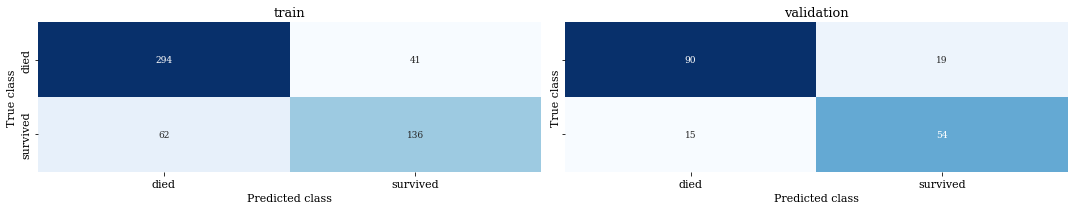

In [41]:
evaluate_model(lr_model_si)

In [42]:
lr_model_si.steps

[('mapper',
  DataFrameMapper(drop_cols=[],
                  features=[(['age'], [StandardScaler()]),
                            (['siblings_spouses'], [StandardScaler()]),
                            (['parents_children'], [StandardScaler()]),
                            (['ticket_class'], [StandardScaler()]),
                            (['fare'], [StandardScaler()]),
                            (['sex'], [OneHotEncoder()]),
                            (['embarked_at'], [OneHotEncoder()])])),
 ('imputer', SimpleImputer()),
 ('classifier', LogisticRegression(random_state=42))]

In [43]:
clf = lr_model_si.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

array([[-0.64958493, -0.42053457, -0.03837994, -0.91692711,  0.04865513,
         1.34650708, -1.3465123 ,  0.43543752, -0.17852602, -0.25691671]])

In [44]:
complete_mapper.transformed_names_

['age',
 'siblings_spouses',
 'parents_children',
 'ticket_class',
 'fare',
 'sex_x0_female',
 'sex_x0_male',
 'embarked_at_x0_C',
 'embarked_at_x0_Q',
 'embarked_at_x0_S']

<AxesSubplot:>

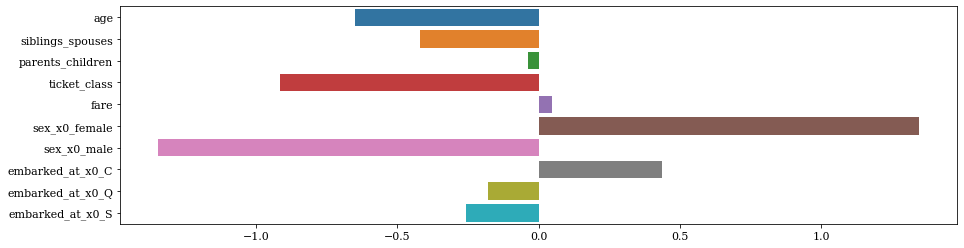

In [45]:
sns.barplot(
    x=clf.coef_[0],
    y=complete_mapper.transformed_names_,
)

un poco más ordenado, usando un dataframe para ordenar esa data...

<AxesSubplot:xlabel='coeficiente', ylabel='feature'>

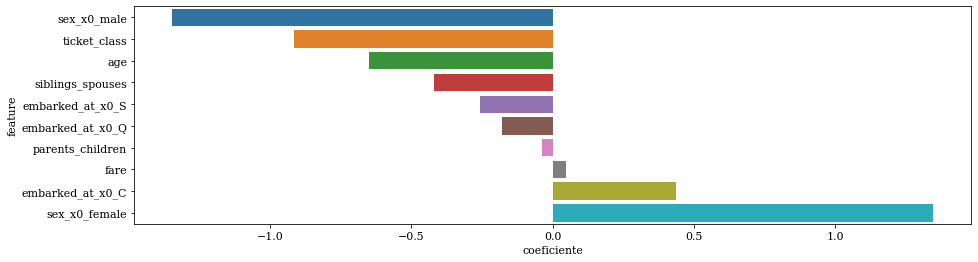

In [46]:
df_importance = pd.DataFrame({
    'feature': complete_mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
validation,0.808989,0.739726,0.782609,0.760563


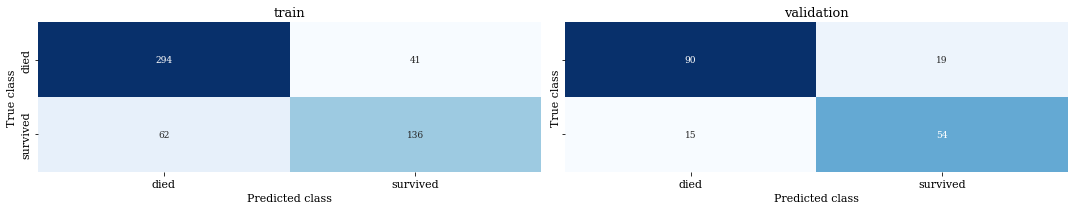

'LR Iterative Imputer'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
validation,0.825843,0.771429,0.782609,0.776978


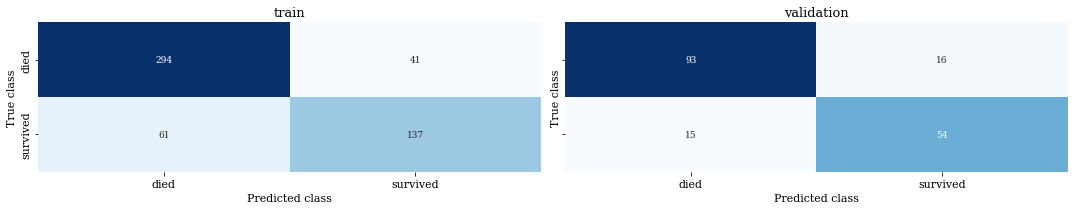

In [47]:
lr_model_ii = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_ii.fit(train, train.survived)

evaluate_model(lr_model_si, title='LR Simple Imputer')
evaluate_model(lr_model_ii, title='LR Iterative Imputer')

# Segundo modelo: K nearest neighbors

In [48]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.838649,0.858974,0.676768,0.757062
validation,0.825843,0.806452,0.724638,0.763359


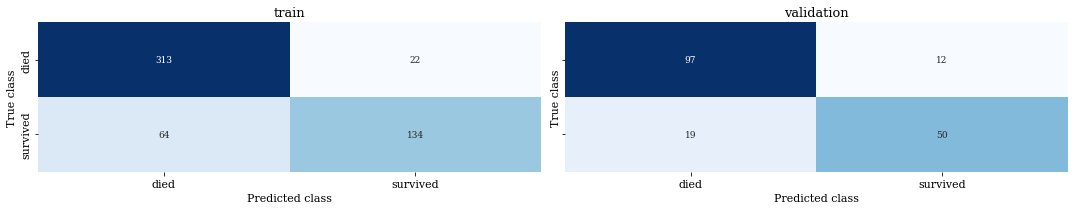

In [49]:
K = 10

knn_model = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.survived)

evaluate_model(knn_model, title='Knn')

# Tercer modelo: Arboles de decisión

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

In [51]:
label_binarizer_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [LabelBinarizer()]),
    (['embarked_at'], [OneHotEncoder()]),
])

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.988743,0.994845,0.974747,0.984694
validation,0.752809,0.671233,0.710145,0.690141


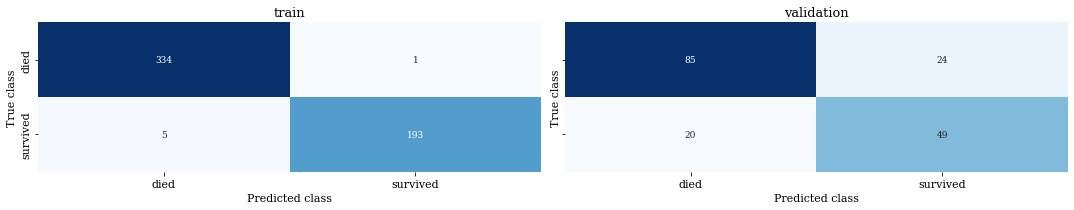

In [52]:
tree_model = DecisionTreeClassifier(random_state=42)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.survived)

evaluate_model(dt_model, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.833021,0.826347,0.696970,0.756164
validation,0.792135,0.742424,0.710145,0.725926


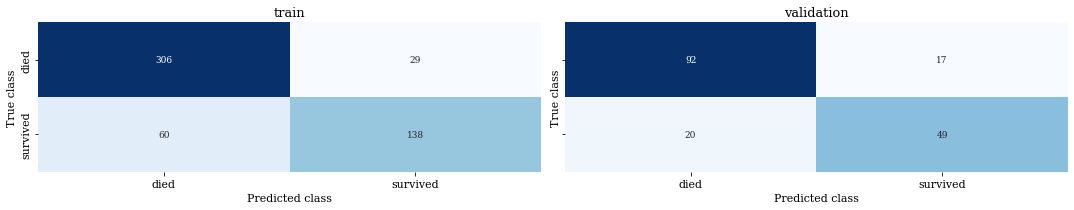

In [53]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.survived)

evaluate_model(dt_model, title='Decision Tree')

In [54]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

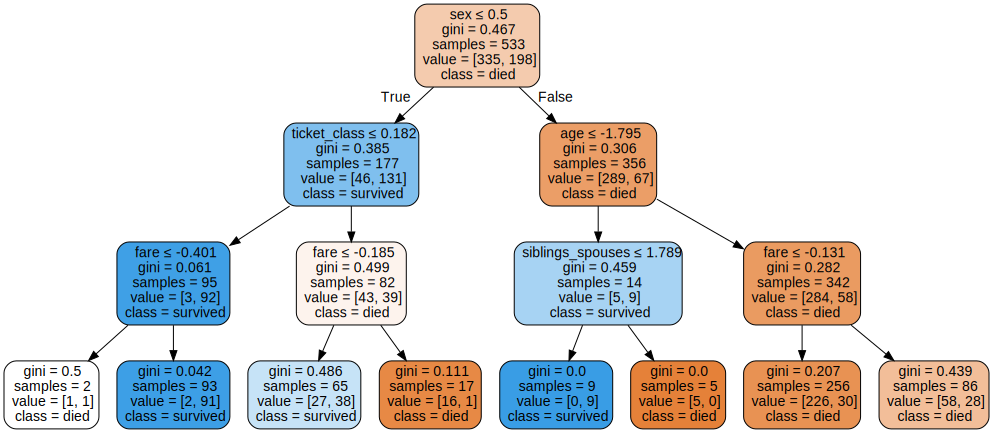

In [55]:
graph_tree(tree_model, label_binarizer_mapper.transformed_names_)

# Cuarto modelo: Random Forests

In [56]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.988743,0.989796,0.979798,0.984772
validation,0.792135,0.728571,0.739130,0.733813


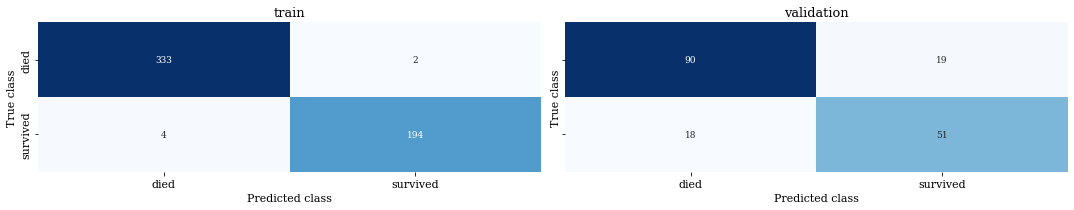

In [57]:
forest_model = RandomForestClassifier(random_state=42)
# n_estimators? max_depth=3?, max_features=2?

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.survived)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
validation,0.820225,0.877551,0.623188,0.728814


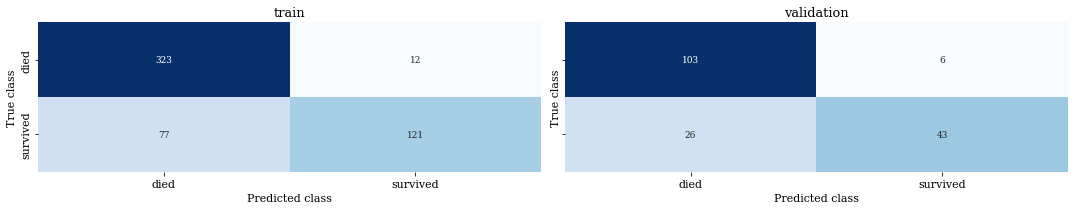

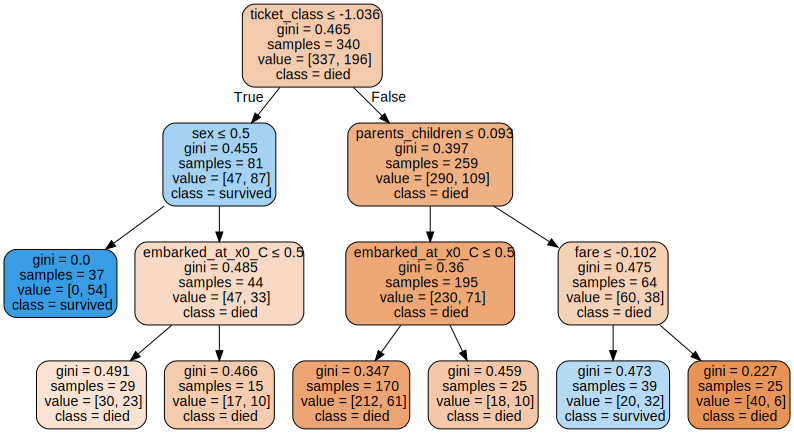

In [58]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=2, random_state=42)

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.survived)

evaluate_model(rf_model, title='Random Forest')

graph_tree(forest_model.estimators_[0], col_names=label_binarizer_mapper.transformed_names_)

# Bonus: Grid Search

In [59]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_estimators': [100, 200], 
              'max_depth':[3, 5, 8],
              'max_features': [2, 5]}

clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train, train.survived)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
evaluate_model(rf_model, title='Random Forest')

evaluate_model(gs_pipe, title='Random Forest after Cross Validation')

# Quinto modelo: Gradient Boosted Trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
boost_model = GradientBoostingClassifier(random_state=42)

boo_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

boo_model.fit(train, train.survived)

evaluate_model(boo_model, title='Gradient Boosting')

In [ ]:
graph_tree(boost_model.estimators_[1][0], col_names=label_binarizer_mapper.transformed_names_)

# Bonus: Features polinomicas en LR

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
lr_model_pf = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(max_iter=3000, random_state=42)),
])

lr_model_pf.fit(train, train.survived)

evaluate_model(lr_model_ii, title='LR')
evaluate_model(lr_model_pf, title='LR con features polinomicas')

# El mejor modelo...


Es accuracy la mejor métrica?


In [ ]:
evaluate_model(lr_model_si, title='LR Simple Imputer', show_cm=False)
evaluate_model(lr_model_ii, title='LR Iterative Imputer', show_cm=False)
evaluate_model(lr_model_pf, title='LR con features polinomicas', show_cm=False)
evaluate_model(knn_model, title='Knn', show_cm=False)
evaluate_model(dt_model, title='Decision Tree', show_cm=False)
evaluate_model(rf_model, title='Random Forest', show_cm=False)
evaluate_model(gs_pipe, title='Random Forest after Cross Validation', show_cm=False)
evaluate_model(boo_model, title='Gradient Boosting', show_cm=False)

In [ ]:
chosen_model = lr_model_pf 
evaluate_model(chosen_model, title='Chosen model', set_names=('train', 'validation', 'test'), show_cm=False)